## News Stream

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import sovai as sov

sov.basic_auth("your_email@example.com", "your_password")

True

In [7]:
sov.token_auth(token="your_token_here")

#### Processed Dataset

In [8]:
df_news = sov.data("news/daily", start_date="2017-03-30", tickers=["MSFT","TSLA", "AAPL","META"])

In [5]:
df_news.sort_values("date")

AttributeError: 'NoneType' object has no attribute 'sort_values'

In [47]:
import time
# https://colab.research.google.com/drive/18sJmcRo2tQRN5rSlLk6pGANJ-SgCdvCS?usp=sharing#scrollTo=wtZ83weFHY-d
# Your function call
df_price = sov.data("market/prices", tickers=["MSFT","TSLA", "AAPL","META"])


In [48]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact

# Get the unique set of tickers from both DataFrames
tickers = sorted(set(df_price.index.get_level_values("ticker")).intersection(df_news.index.get_level_values("ticker")))

# Create the plot using Plotly Express
def create_plot(ticker, variable):
    # Resample df_price to calculate weekly returns for the selected ticker
    df_price_weekly = df_price.query(f"ticker == '{ticker}'").reset_index().set_index("date").resample("W-FRI")["closeadj"].last().pct_change()
    
    # Resample df_news to align with weekly frequency for the selected ticker
    df_news_weekly = df_news.query(f"ticker == '{ticker}'").reset_index().set_index("date").resample("W-FRI")[["relevance", "sentiment", "polarity", "tone"]].last()
    
    # Merge df_price_weekly with df_news_weekly
    df_merged = pd.merge(df_news_weekly, df_price_weekly.rename("returns"),
                         left_index=True, right_index=True, how="left")
    
    fig = px.line(df_merged.reset_index(), x="date", y=[variable, "returns"],
                  labels={"variable": "Variable", "value": "Value", "date": "Date"},
                  title=f"{variable.capitalize()} and Weekly Returns for {ticker}")
    
    # Set the y-axis for the selected variable on the left
    fig.update_traces(yaxis="y1", selector=dict(name=variable))
    
    # Set the y-axis for returns on the right
    fig.update_traces(yaxis="y2", selector=dict(name="returns"))
    
    # Configure the y-axes
    fig.update_layout(
        yaxis=dict(
            title=variable.capitalize(),
            titlefont=dict(color="blue"),
            tickfont=dict(color="blue")
        ),
        yaxis2=dict(
            title="Weekly Returns",
            titlefont=dict(color="red"),
            tickfont=dict(color="red"),
            overlaying="y",
            side="right"
        ),
        legend=dict(
            title="",
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    
    return fig

# Create dropdown widgets
ticker_dropdown = widgets.Dropdown(
    options=tickers,
    value=tickers[0],
    description="Ticker:"
)

variable_dropdown = widgets.Dropdown(
    options=["relevance", "sentiment", "polarity", "tone"],
    value="tone",
    description="Variable:"
)

# Use the interact function to update the plot based on the dropdown selections
@interact(ticker=ticker_dropdown, variable=variable_dropdown)
def update_plot(ticker, variable):
    fig = create_plot(ticker, variable)
    fig.show()

interactive(children=(Dropdown(description='Ticker:', options=('AAPL', 'MSFT', 'TSLA'), value='AAPL'), Dropdow…

### Time Series Topic Modelling

In [96]:
df_polarity = sov.data("news/sentiment_score")

In [145]:
## I think I have kindoff figured it out here. 
import pandas as pd

# Assuming your DataFrame is named 'df_polarity' and has a 'date' column for the time series index

# Select the numeric columns (excluding the calculation column)
numeric_columns = df_polarity.select_dtypes(include='number').columns

df_polarity_z_scored = df_polarity.copy()

# Perform groupby z-scoring
df_polarity_z_scored[numeric_columns] = df_polarity.groupby('calculation')[numeric_columns].transform(lambda x: (x - x.mean()) / x.std())

# Calculate the rolling mean over a 7-day window
df_polarity_z_scored[numeric_columns] = df_polarity_z_scored[numeric_columns].rolling(window='7D').mean()


df_polarity_z_scored[numeric_columns] = df_polarity_z_scored[numeric_columns].sub(df_polarity_z_scored[numeric_columns].mean(axis=1), axis=0)

In [149]:
df_polarity_z_scored.corr().sort_values("monetary_policy")

/var/folders/tj/2qbc2n2x1234_l7b3z5y06740000gn/T/ipykernel_13343/3702737683.py:1: FutureWarning:

The default value of numeric_only in CustomDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,monetary_policy,fiscal_policy,economic_growth,inflation,interest_rates,business_cycles,government_debt_deficit,quantitative_easing,monetary_policy_transmission,international_trade,emerging_economies,international_monetary_system,international_finance,trade_agreements,foreign_direct_investment,migration_remittances,sanctions_embargoes,foreign_exchange_markets,energy_resources,healthcare_pharma,real_estate_housing,consumer_spending_retail,manufacturing_industrial,transportation_logistics,telecom_internet,tourism_hospitality,agriculture_food,aerospace_defense,utilities_public_services,mining_extraction,chemicals_materials,forestry_paper_products,fishing_aquaculture,textiles_apparel,luxury_goods_services,sports_entertainment,media_publishing,education_services,consulting_business_services,legal_services_regulations,waste_management_recycling,artificial_intelligence,robotics_automation,cybersecurity_data_privacy,cryptocurrency_blockchain,quantum_computing_crypto,technology_innovation,intellectual_property_patents,nanotech_advanced_materials,space_commercialization_exploration,renewable_energy,digital_economy,financial_technology_fintech,robo_advisors,high_frequency_trading,algorithmic_trading,environmental_sustainability,climate_change,income_inequality,human_rights_business,poverty_alleviation,sustainable_development,financial_inclusion,circular_economy,economic_inequality,welfare_inequality,international_development_aid,nonprofit_charitable_orgs,labor_market,labor_productivity,education_human_capital,demographic_shifts_aging,sharing_economy_gig_work,small_business_entrepreneurship,geopolitical_events,public_health_disease_control,urbanization_city_planning,infrastructure,financial_markets_investing,insurance_risk_management,economic_forecasting_modeling,corporate_governance,market_regulation,antitrust_competition_policy,commodities_markets,private_equity_venture_capital,sovereign_wealth_funds,pension_funds,hedge_funds,exchange_traded_funds,mergers_acquisitions,initial_public_offerings,bond_markets,derivative_markets,yield_curve,credit_ratings,financial_stability,systemic_risk,short_selling,leveraged_buyouts,distressed_debt,angel_investing,crowdfunding,supply_chain_management,central_bank_digital_currencies,market_sentiment
geopolitical_events,-0.423,0.210,-0.243,-0.183,-0.103,0.363,0.468,0.340,0.246,-0.300,0.551,0.006,-0.066,0.203,-0.227,0.243,0.488,-0.369,-0.217,-0.416,-0.303,-0.351,-0.241,-0.417,-0.542,-0.122,-0.466,0.472,-0.076,-0.353,-0.342,-0.588,-0.296,-0.491,-0.198,0.464,0.448,-0.370,-0.436,0.435,-0.476,-0.083,-0.545,0.366,-0.337,0.509,-0.366,0.189,-0.555,-0.105,-0.340,-0.191,-0.364,0.384,0.424,0.380,0.350,0.057,-0.402,0.672,0.050,0.044,-0.322,0.477,0.244,-0.412,0.395,0.404,0.389,0.437,-0.489,-0.105,-0.264,-0.427,1.000,-0.286,-0.471,-0.052,-0.098,0.090,0.392,0.290,-0.542,0.413,-0.116,-0.465,0.469,-0.138,0.248,-0.595,-0.489,-0.379,-0.341,0.272,0.367,0.080,-0.292,0.292,0.522,0.273,0.360,0.376,-0.031,-0.387,-0.091,-0.184
antitrust_competition_policy,-0.396,0.436,-0.228,-0.301,-0.059,0.333,0.501,0.237,0.150,-0.153,0.128,-0.167,-0.316,0.194,-0.210,0.211,0.343,-0.277,-0.155,-0.128,-0.196,-0.244,-0.292,-0.356,-0.372,-0.222,-0.409,0.010,-0.029,-0.210,-0.161,-0.416,-0.273,-0.234,-0.231,0.328,0.418,-0.257,-0.134,0.411,-0.229,-0.338,-0.373,0.244,-0.321,0.372,-0.276,0.251,-0.303,-0.170,-0.300,-0.224,-0.287,0.429,0.337,0.339,0.118,0.049,-0.338,0.362,0.037,-0.060,-0.244,0.290,0.201,-0.372,0.130,0.296,0.342,0.278,-0.345,0.010,-0.046,-0.373,0.413,-0.064,-0.278,-0.230,-0.134,0.225,0.413,0.359,-0.415,1.000,-0.216,-0.252,0.368,-0.060,0.158,-0.451,-0.173,-0.332,-0.114,0.172,0.207,0.091,-0.075,0.357,0.447,0.361,0.432,0.204,-0.221,-0.204,-0.284,-0.024
emerging_economies,-0.380,-0.015,-0.022,0.008,-0.113,0.274,0.275,0.185,0.130,-0.192,1.000,0.112,0.168,0.158,-0.107,0.270,0.268,-0.106,-0.173,-0.232,-0.253,-0.349,-0.384,-0.386,-0.224,-0.089,-0.338,0.253,-0.006,-0.337,-0.371,-0.445,-0.301,-0.410,-0.021,0.250,0.123,-0.275,-0.282,0.270,-0.467,0.060,

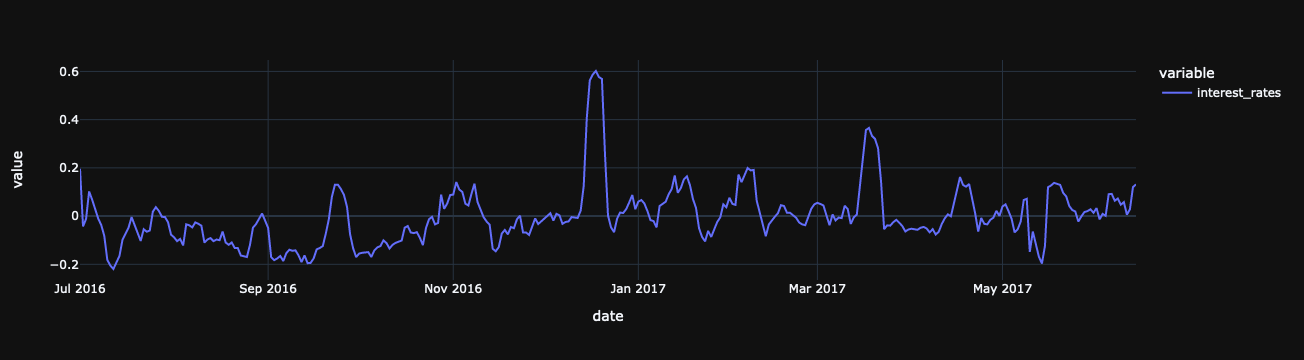

In [151]:
df_polarity_z_scored.query("calculation == 'sentiment_score_mean'")["interest_rates"].plot()

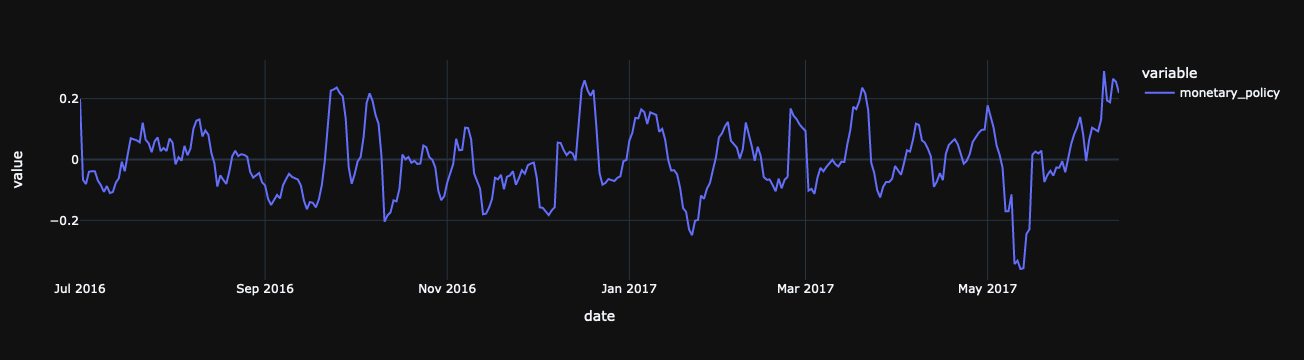

In [146]:
df_polarity_z_scored.query("calculation == 'sentiment_score_median'")["monetary_policy"].plot()

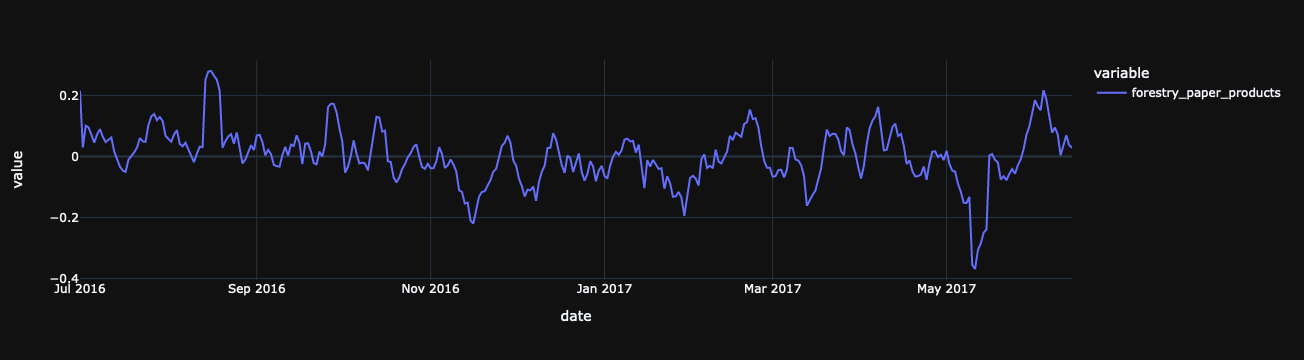

In [150]:
df_polarity_z_scored.query("calculation == 'sentiment_score_median'")["forestry_paper_products"].plot()

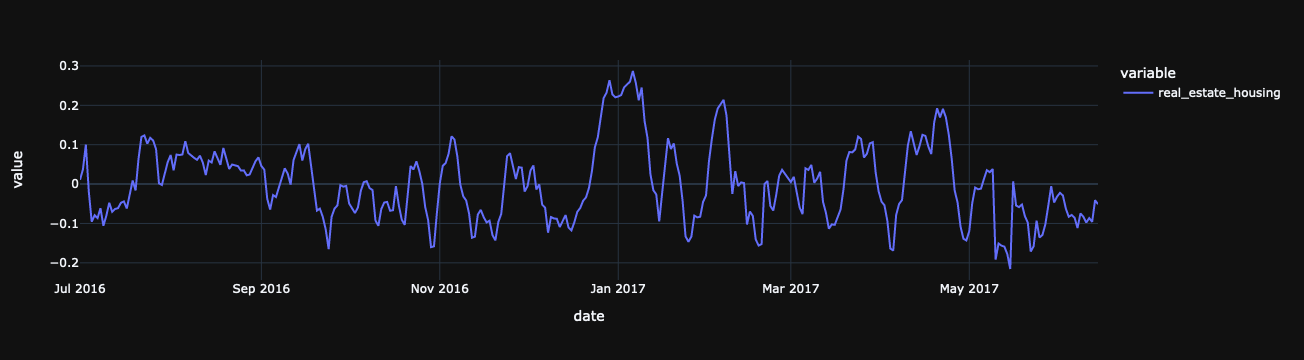

In [148]:
df_polarity_z_scored.query("calculation == 'sentiment_score_median'")["real_estate_housing"].plot()

In [112]:
df_polarity_z_scored

,calculation,monetary_policy,fiscal_policy,economic_growth,inflation,interest_rates,business_cycles,government_debt_deficit,quantitative_easing,monetary_policy_transmission,international_trade,emerging_economies,international_monetary_system,international_finance,trade_agreements,foreign_direct_investment,migration_remittances,sanctions_embargoes,foreign_exchange_markets,energy_resources,healthcare_pharma,real_estate_housing,consumer_spending_retail,manufacturing_industrial,transportation_logistics,telecom_internet,tourism_hospitality,agriculture_food,aerospace_defense,utilities_public_services,mining_extraction,chemicals_materials,forestry_paper_products,fishing_aquaculture,textiles_apparel,luxury_goods_services,sports_entertainment,media_publishing,education_services,consulting_business_services,legal_services_regulations,waste_management_recycling,artificial_intelligence,robotics_automation,cybersecurity_data_privacy,cryptocurrency_blockchain,quantum_computing_crypto,technology_innovation,intellectual_property_patents,nanotech_advanced_materials,space_commercialization_exploration,renewable_energy,digital_economy,financial_technology_fintech,robo_advisors,high_frequency_trading,algorithmic_trading,environmental_sustainability,climate_change,income_inequality,human_rights_business,poverty_alleviation,sustainable_development,financial_inclusion,circular_economy,economic_inequality,welfare_inequality,international_development_aid,nonprofit_charitable_orgs,labor_market,labor_productivity,education_human_capital,demographic_shifts_aging,sharing_economy_gig_work,small_business_entrepreneurship,geopolitical_events,public_health_disease_control,urbanization_city_planning,infrastructure,financial_markets_investing,insurance_risk_management,economic_forecasting_modeling,corporate_governance,market_regulation,antitrust_competition_policy,commodities_markets,private_equity_venture_capital,sovereign_wealth_funds,pension_funds,hedge_funds,exchange_traded_funds,mergers_acquisitions,initial_public_offerings,bond_markets,derivative_markets,yield_curve,credit_ratings,financial_stability,systemic_risk,short_selling,leveraged_buyouts,distressed_debt,angel_investing,crowdfunding,supply_chain_management,central_bank_digital_currencies,market_sentiment
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-01,sentiment_score_mean,0.048,-0.205,-1.139,-0.163,-0.030,-0.269,0.587,-0.111,-0.005,-0.847,-0.767,-0.877,-1.808,-0.530,-1.244,-0.329,0.998,-0.764,0.492,-0.414,-0.182,-0.410,1.220,0.145,-0.316,-0.146,0.118,-0.766,0.913,0.270,0.465,0.251,-0.129,-0.345,-1.522,-0.632,0.183,-0.825,-0.225,-1.296,0.536,-0.633,-0.811,0.486,-0.761,0.004,-0.847,3.173,0.318,-0.985,0.520,-0.212,-1.274,-0.497,-0.253,-0.170,0.419,0.228,-0.720,0.221,-0.789,0.271,-1.215,-0.639,-0.984,-0.759,0.888,0.060,-0.271,-0.316,0.262,-0.315,-0.202,-1.139,0.058,-0.213,0.008,0.510,0.486,-0.084,-0.342,-0.256,-0.010,-0.026,-0.166,0.261,-0.967,-0.884,-0.350,-0.648,0.841,-1.375,-1.056,0.006,0.189,-0.589,-0.451,-0.422,-0.187,-0.093,-0.243,-0.129,0.337,-0.232,-0.996,0.034
2016-07-01,sentiment_score_median,-0.018,-0.222,-0.732,-0.243,-0.123,-0.218,0.167,-0.146,-0.104,-0.546,-0.468,-0.546,-0.970,-0.357,-0.740,-0.303,0.517,-0.468,0.111,-0.228,-0.206,-0.356,0.472,-0.067,-0.245,-0.193,-0.022,-0.402,0.475,-0.008,0.098,-0.002,-0.157,-0.239,-0.926,-0.355,0.022,-0.474,-0.249,-0.708,0.163,-0.398,-0.504,0.193,-0.526,-0.093,-0.501,1.431,-0.054,-0.577,0.147,-0.287,-0.808,-0.359,-0.223,-0.139,0.170,0.067,-0.535,0.080,-0.504,0.111,-0.802,-0.435,-0.668,-0.558,0.504,0.014,-0.192,-0.218,-0.003,-0.259,-0.279,-0.743,0.012,-0.188,-0.137,0.197,0.104,-0.187,-0.308,-0.230,-0.163,-0.098,-0.137,-0.048,-0.557,-0.562,-0.313,-0.489,0.314,-0.740,-0.697,-0.106,-0.002,-0.409,-0.343,-0.306,-0.191,-0.178,-0.223,-0.187,0.111,-0.191,-0.684,-0.108
2016-07-01,sentiment_score_variance,-0.023,-0.033,-0.524,-0.016,-0.125,-0.177,0.548,0.333,-0.051,-0.558,-0.675,-0.056,-0.2

In [ ]:
df_polarity.groupby("calculation")

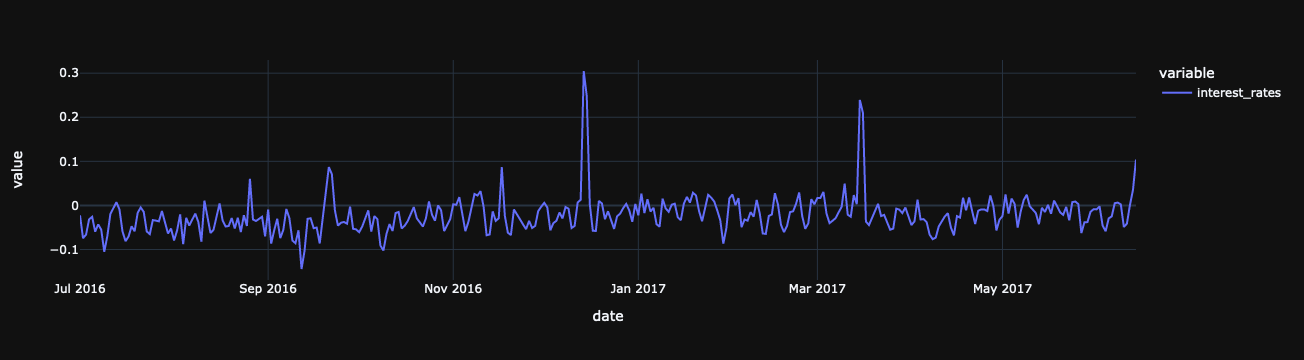

In [99]:
df_polarity.query("calculation == 'sentiment_score_mean'")["interest_rates"].plot()

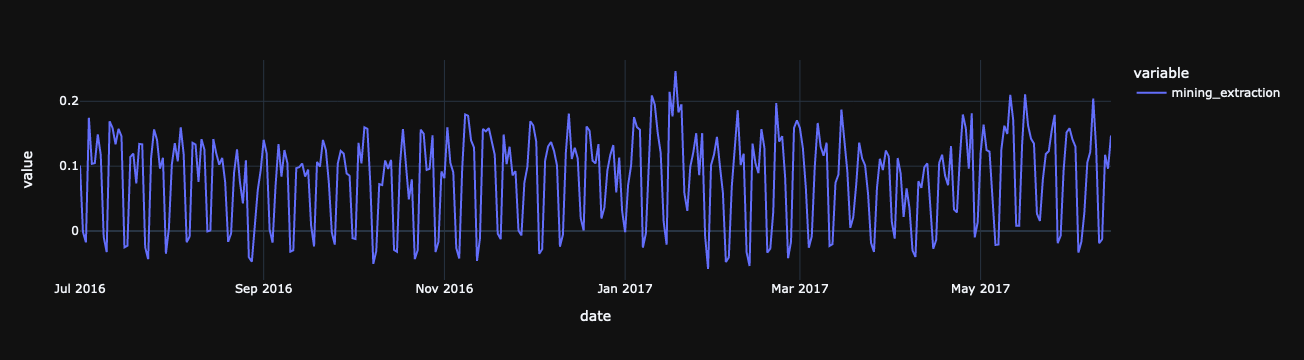

In [102]:
df_polarity.query("calculation == 'sentiment_score_mean'")["mining_extraction"].plot()

In [84]:
import pandas as pd

# Select the numeric columns (excluding the calculation column)
numeric_columns = df_polarity.select_dtypes(include='number').columns

df_polarity_percentile = df_polarity.copy()
# Calculate the percentile for the numeric columns
df_polarity_percentile[numeric_columns] = df_polarity_percentile.groupby("calculation").rank(axis=0,pct=True).rank(axis=1,pct=True) * 100



In [85]:
df_polarity_percentile

,calculation,monetary_policy,fiscal_policy,economic_growth,inflation,interest_rates,business_cycles,government_debt_deficit,quantitative_easing,monetary_policy_transmission,international_trade,emerging_economies,international_monetary_system,international_finance,trade_agreements,foreign_direct_investment,migration_remittances,sanctions_embargoes,foreign_exchange_markets,energy_resources,healthcare_pharma,real_estate_housing,consumer_spending_retail,manufacturing_industrial,transportation_logistics,telecom_internet,tourism_hospitality,agriculture_food,aerospace_defense,utilities_public_services,mining_extraction,chemicals_materials,forestry_paper_products,fishing_aquaculture,textiles_apparel,luxury_goods_services,sports_entertainment,media_publishing,education_services,consulting_business_services,legal_services_regulations,waste_management_recycling,artificial_intelligence,robotics_automation,cybersecurity_data_privacy,cryptocurrency_blockchain,quantum_computing_crypto,technology_innovation,intellectual_property_patents,nanotech_advanced_materials,space_commercialization_exploration,renewable_energy,digital_economy,financial_technology_fintech,robo_advisors,high_frequency_trading,algorithmic_trading,environmental_sustainability,climate_change,income_inequality,human_rights_business,poverty_alleviation,sustainable_development,financial_inclusion,circular_economy,economic_inequality,welfare_inequality,international_development_aid,nonprofit_charitable_orgs,labor_market,labor_productivity,education_human_capital,demographic_shifts_aging,sharing_economy_gig_work,small_business_entrepreneurship,geopolitical_events,public_health_disease_control,urbanization_city_planning,infrastructure,financial_markets_investing,insurance_risk_management,economic_forecasting_modeling,corporate_governance,market_regulation,antitrust_competition_policy,commodities_markets,private_equity_venture_capital,sovereign_wealth_funds,pension_funds,hedge_funds,exchange_traded_funds,mergers_acquisitions,initial_public_offerings,bond_markets,derivative_markets,yield_curve,credit_ratings,financial_stability,systemic_risk,short_selling,leveraged_buyouts,distressed_debt,angel_investing,crowdfunding,supply_chain_management,central_bank_digital_currencies,market_sentiment
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-01,polarity_score_mean,89.623,45.755,18.868,66.038,73.585,52.830,87.736,58.019,76.415,15.094,16.038,14.151,0.943,33.019,4.245,6.132,99.057,9.906,85.849,33.019,55.189,51.415,98.113,60.377,41.509,37.264,74.528,11.321,97.170,61.321,75.472,77.358,33.019,35.849,4.245,19.811,78.302,25.000,56.604,2.358,92.453,27.358,20.755,95.283,27.358,65.094,25.000,100.000,53.774,7.547,83.019,58.019,16.981,34.906,47.170,41.509,91.509,81.604,27.358,81.604,23.113,90.566,17.925,29.245,9.906,21.698,96.226,70.755,50.000,45.755,86.792,55.189,37.264,12.264,84.434,44.340,67.925,88.679,93.396,71.698,41.509,62.264,64.151,69.811,51.415,84.434,6.132,13.208,68.868,30.660,94.340,2.358,8.491,63.208,79.717,39.623,48.113,30.660,66.981,59.434,38.679,49.057,79.717,43.396,23.113,72.642
2016-07-01,polarity_score_median,71.698,68.868,9.434,5.660,19.811,39.151,13.208,82.075,39.151,19.811,82.075,87.736,93.868,39.151,82.075,9.434,98.113,87.736,45.755,82.075,19.811,27.830,45.755,27.830,76.415,64.623,64.623,93.868,99.057,33.491,45.755,33.491,39.151,78.774,23.585,78.774,85.377,91.509,51.887,71.698,51.887,64.623,71.698,51.887,33.491,57.547,85.377,0.943,9.434,87.736,96.698,45.755,19.811,57.547,51.887,57.547,90.094,74.528,33.491,76.415,71.698,93.868,15.566,64.623,45.755,57.547,96.698,93.868,64.623,64.623,45.755,39.151,16.981,19.811,100.000,23.585,13.208,39.151,15.566,3.302,27.830,64.623,5.660,33.491,45.755,1.887,90.094,23.585,3.302,9.434,27.830,71.698,9.434,33.491,57.547,45.755,76.415,13.208,51.887,57.547,57.547,27.830,82.075,27.830,5.660,64.623
2016-07-01,polarity_score_variance,66.509,73.585,24.528,58.491,75.472,51.887,87.736,86.7

ticker,MSFT,TSLA,AMZN,AAPL,FB,GOOG
ticker,,,,,,
MSFT,1.000000,0.224509,0.051286,0.309202,-0.085306,0.277285
TSLA,0.224509,1.000000,0.555163,0.520831,-0.241285,0.283434
AMZN,0.051286,0.555163,1.000000,0.494081,-0.053698,0.043217
AAPL,0.309202,0.520831,0.494081,1.000000,-0.048227,0.320089
FB,-0.085306,-0.241285,-0.053698,-0.048227,1.000000,-0.088186
GOOG,0.277285,0.283434,0.043217,0.320089,-0.088186,1.000000
